On colab

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

Jupyter

In [4]:
import torch

In [82]:
import torchvision.datasets as datasets
import torchvision.transforms as T
import numpy as np
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.loader import DataLoader

import time

import skimage as ski
from skimage.segmentation import  slic

import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool, global_add_pool

Dataset loading

Computing, for every superpixel 
+ Average color (R, G and B channels)
+ Standard deviation of colors
+ Geometric centroid
+ Standard deviation of position 

In [69]:
def compute_features(img_np, n_segments, compactness):
    dim0, dim1, _ = img_np.shape
    s = slic(img_np, n_segments, compactness, start_label=0)
    # rag_mean_color() fails when image is segmented into 1 superpixel 
    if np.any(s):
        g = ski.future.graph.rag_mean_color(img_np, s)
        n = g.number_of_nodes()
        edge_index = np.array(g.edges).T
    else: 
        n = 1
        edge_index = np.array([])
    s1 = np.zeros([n, 3])  # for mean color and std deviation
    s2 = np.zeros([n, 3])  # for std deviation
    pos1 = np.zeros([n, 2]) # for centroid
    pos2 = np.zeros([n, 2]) # for centroid std deviation
    num_pixels = np.zeros([n, 1])
    for idx in range(dim0 * dim1):
            idx_i, idx_j = idx % dim0, int(idx / dim0)
            node = s[idx_i][idx_j] - 1
            s1[node][0]  += img_np[idx_i][idx_j][0]
            s2[node][0]  += pow(img_np[idx_i][idx_j][0], 2)
            s1[node][1]  += img_np[idx_i][idx_j][1]
            s2[node][1]  += pow(img_np[idx_i][idx_j][1], 2)
            s1[node][2]  += img_np[idx_i][idx_j][2]
            s2[node][2]  += pow(img_np[idx_i][idx_j][2], 2)
            pos1[node][0] += idx_i
            pos1[node][1] += idx_j
            pos2[node][0] += pow(idx_i, 2)
            pos2[node][1] += pow(idx_j, 2)
            num_pixels[node][0] += 1
    x = []
    s1 = s1/num_pixels
    avg_color = s1
    x.append(avg_color[:,0])
    x.append(avg_color[:,1])
    x.append(avg_color[:,2])
    s2 = s2/num_pixels
    std_dev = np.sqrt(np.abs((s2 - s1*s1)))
    x.append(std_dev[:,0])
    x.append(std_dev[:,1])
    x.append(std_dev[:,2])
    pos1 = pos1/num_pixels
    pos = pos1
    x.append(pos[:,0])
    x.append(pos[:,1])
    pos2 = pos2/num_pixels
    std_dev_centroid = np.sqrt(np.abs(pos2 - pos1*pos1))
    x.append(std_dev_centroid[:,0])
    x.append(std_dev_centroid[:,1])
    features = np.stack(x, axis=1)
    return features, edge_index, pos

In [35]:
ds = datasets.CIFAR10(root="cifar10/test", train=False, download=True, transform=T.ToTensor())

Files already downloaded and verified


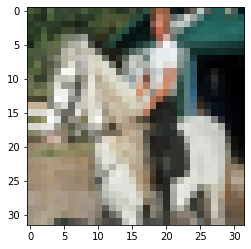

In [73]:
n_segments = 75
compactness = 0.1

img, y = ds[56]
img_np = torch.stack([img[0], img[1], img[2]], dim=2).numpy()
features, edge_index, pos = compute_features(img_np, n_segments, compactness)
plt.imshow(img_np)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


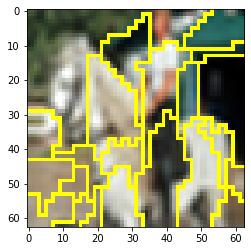

In [74]:
s = slic(img_np, n_segments, compactness, start_label=0)
plt.imshow(ski.segmentation.mark_boundaries(img_np, s, mode='subpixel'))

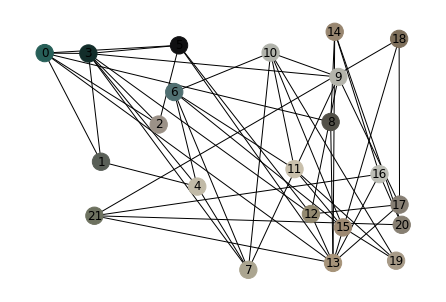

In [75]:
g = Data(x=torch.from_numpy(features).to(torch.float), edge_index=torch.from_numpy(edge_index).to(torch.long), pos=torch.from_numpy(pos).to(torch.float), y=y)
nx_g = to_networkx(g, to_undirected=True)
nx_color = features[:,:3]
nx_pos = dict(zip(range(g.num_nodes), pos))
nx.draw(nx_g, pos=nx_pos, node_color=nx_color, with_labels=True)

In [78]:
class ColorSLIC(InMemoryDataset):
    def __init__(self, 
                 root=None, 
                 n_segments= 75,  
                 compactness = 0.1, 
                 dataset = 'cifar10',
                 train = True):
        self.train = train
        self.n_segments = n_segments
        self.compactness = compactness
        self.dataset_name = dataset

        if root is None:
            split = 'train' if self.train else 'test'
            self.root = f'./{self.dataset_name}./{split}'
        else:
            self.root = root

        self.is_pre_loaded = True
        super().__init__(root=self.root, transform=None)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
        self.get_stats()
        print(self.dataset_name + " loaded.")
        print(f"Average number of nodes: {self.avg_num_nodes} with standard deviation {self.std_deviation_num_nodes}")
        print(f"Average number of edges: {self.avg_num_edges} with standard deviation {self.std_deviation_num_edges}")

    def get_targets(self):
        return torch.cat([d.y for d in self])

    def load(self):
        self.is_pre_loaded = False

        if self.dataset_name == 'cifar10':
            data = datasets.CIFAR10(self.root, train=self.train, download=True, transform=T.ToTensor())
        elif self.dataset_name =='cifar100':
            data = datasets.CIFAR100(self.root, train=self.train, download=True, transform=T.ToTensor())
        elif self.dataset_name == 'stl10':
            split = 'train' if self.train else 'test'
            data = datasets.STL10(self.root, split=split, download=True, transform=T.ToTensor())

        img_total = len(data)
        print(f'Loading {img_total} images with n_segments = {self.n_segments} ...')
        print(f'Computing features: ')

        t = time.time()
        data_list = [self.create_data_obj(d) for d in data]
        t = time.time() - t
        self.loading_time = t
        print(f'Done in {t}s')
        self.save_stats(data_list)
        return self.collate(data_list)

    def create_data_obj(self, d):
            img, y = d
            img_np = torch.stack([img[0], img[1], img[2]], dim=2).numpy()
            features, edge_index, pos = compute_features(img_np, self.n_segments, self.compactness)
            return Data(x=torch.from_numpy(features).to(torch.float),
                        edge_index=torch.from_numpy(edge_index).to(torch.float),
                        pos=torch.from_numpy(pos).to(torch.float),
                        y=y)

    def save_stats(self, data):
        nodes = [d.num_nodes for d in data]
        edges = [d.num_edges for d in data]
        self.avg_num_nodes = np.average(nodes)
        self.std_deviation_num_nodes = np.std(nodes)
        self.avg_num_edges = np.average(edges)
        self.std_deviation_num_edges = np.std(edges)
    
    def get_stats(self):
        if self.is_pre_loaded:
            data_list = [self[i] for i in range(len(self))]
            self.save_stats(data_list)
            self.loading_time = 0

    @property
    def processed_file_names(self):
        return ['data.pt']
    
    def process(self):
        data, slices = self.load()
        torch.save((data, slices), self.processed_paths[0])

In [79]:
dataset_name = 'cifar10'
n_segments = 75
compactness = 0.1

train_ds = ColorSLIC(dataset=dataset_name,
                     n_segments=n_segments,
                     compactness=compactness, 
                     train=True)
test_ds  = ColorSLIC(dataset=dataset_name,
                     n_segments=n_segments,
                     compactness=compactness, 
                     train=False)
train_loader = DataLoader(train_ds, batch_size=64)
test_loader  = DataLoader(test_ds, batch_size=64)

Processing...


Files already downloaded and verified
Loading 50000 images with n_segments = 75 ...
Computing features: 


KeyboardInterrupt: 

Model

In [83]:
class GCN(torch.nn.Module):
    def __init__(self, data):
        super(GCN, self).__init__()
        # using architecture inspired by MNISTSuperpixels example 
        # (https://medium.com/@rtsrumi07/understanding-graph-neural-network-with-hands-on-example-part-2-139a691ebeac)
        hidden_channel_size = 16
        self.initial_conv = GCNConv(data.num_features, hidden_channel_size)
        self.conv1 = GCNConv(hidden_channel_size, hidden_channel_size)
        self.conv2 = GCNConv(hidden_channel_size, hidden_channel_size)
        self.out = nn.Linear(hidden_channel_size*3, data.num_classes)

    def forward(self, x, edge_index, batch_index):
        hidden = self.initial_conv(x, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv1(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = torch.cat([global_mean_pool(hidden, batch_index),
                            global_add_pool(hidden, batch_index),
                            global_max_pool(hidden, batch_index)], dim=1)
        out = self.out(hidden)
        return out 

In [84]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    for batch, b in enumerate(dataloader):
        b.to(device)
        pred = model(b.x, b.edge_index, b.batch)
        loss = loss_fn(pred, b.y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch
            print(f"loss: {loss:>7f}  [{(current*64):>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for d in dataloader:
            d.to(device)
            pred = model(d.x, d.edge_index, d.batch)
            test_loss += loss_fn(pred, d.y).item()
            correct += (pred.argmax(1) == d.y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(train_ds).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer, device)
    test(test_loader, model, loss_fn, device)
print("Done!")